In [1]:
import copy
import gc
import itertools
import os
import pickle
import pprint
import random
import re
import time

# from transformers import BertTokenizer
import warnings
from collections import Counter, defaultdict
from functools import reduce
from itertools import cycle
from random import choice, choices

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np

# import catboost as cb
import optuna
import pandas as pd
import seaborn as sns
import umap
import xgboost as xgb
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from scipy import stats
from scipy.stats import kurtosis, skew
from sklearn import (
    decomposition,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    preprocessing,
    tree,
)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import (
    AdaBoostRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline

# from gensim.models import Word2Vec
from sklearn.preprocessing import (
    FunctionTransformer,
    LabelEncoder,
    PowerTransformer,
    RobustScaler,
)
from sklearn.svm import SVR
from tqdm import tqdm
from tqdm.autonotebook import tqdm

/home/rohit/Desktop/kaggle/virtualenvs/writing_quality/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.__version__

'2.0.3'

In [3]:
class MyConfig:
    INPUT_DIR = "./data"
    seed = 42
    is_time_in_secs = True
    time_divider = 1000 if is_time_in_secs else 1

    num_folds = 10
    num_estimators = 12001
    num_trials_early_stopping = 200

    response_variate = "score"
    use_optuna_tuning = False
    test_size_optuna = 0.3
    num_trials_optuna = 50

    num_features_to_display = 50
    vector_size = 64
    umap_filename = "count_vectoriser_umap2.sav"

In [4]:
cnfg = MyConfig()

In [5]:
tqdm.pandas()
sns.set_style("whitegrid")
warnings.simplefilter("ignore")
random.seed(cnfg.seed)
np.random.seed(cnfg.seed)

# Import Data

In [6]:
traindf = pd.read_csv(f"{cnfg.INPUT_DIR}/train_logs.csv")
train_scores = pd.read_csv(f"{cnfg.INPUT_DIR}/train_scores.csv")
testdf = pd.read_csv(f"{cnfg.INPUT_DIR}/test_logs.csv")

## Essay Constructor

In [7]:
def getEssays(df):
    # Copy required columns
    textInputDf = df[["id", "activity", "cursor_position", "text_change"]].copy()

    # Get rid of text inputs that make no change
    # Note: Shift was unpreditcable so ignored
    textInputDf = textInputDf[textInputDf.activity != "Nonproduction"]

    # Get how much each Id there is
    valCountsArr = textInputDf["id"].value_counts(sort=False).values

    # Holds the final index of the previous Id
    lastIndex = 0

    # Holds all the essays
    essaySeries = pd.Series()

    # Fills essay series with essays
    for index, valCount in enumerate(valCountsArr):
        # Indexes down_time at current Id
        currTextInput = textInputDf[
            ["activity", "cursor_position", "text_change"]
        ].iloc[lastIndex : lastIndex + valCount]

        # Update the last index
        lastIndex += valCount

        # Where the essay content will be stored
        essayText = ""

        # Produces the essay
        for Input in currTextInput.values:
            # Input[0] = activity
            # Input[2] = cursor_position
            # Input[3] = text_change

            # If activity = Replace
            if Input[0] == "Replace":
                # splits text_change at ' => '
                replaceTxt = Input[2].split(" => ")

                # DONT TOUCH
                essayText = (
                    essayText[: Input[1] - len(replaceTxt[1])]
                    + replaceTxt[1]
                    + essayText[Input[1] - len(replaceTxt[1]) + len(replaceTxt[0]) :]
                )
                continue

            # If activity = Paste
            if Input[0] == "Paste":
                # DONT TOUCH
                essayText = (
                    essayText[: Input[1] - len(Input[2])]
                    + Input[2]
                    + essayText[Input[1] - len(Input[2]) :]
                )
                continue

            # If activity = Remove/Cut
            if Input[0] == "Remove/Cut":
                # DONT TOUCH
                essayText = (
                    essayText[: Input[1]] + essayText[Input[1] + len(Input[2]) :]
                )
                continue

            # If activity = Move...
            if "M" in Input[0]:
                # Gets rid of the "Move from to" text
                croppedTxt = Input[0][10:]

                # Splits cropped text by ' To '
                splitTxt = croppedTxt.split(" To ")

                # Splits split text again by ', ' for each item
                valueArr = [item.split(", ") for item in splitTxt]

                # Move from [2, 4] To [5, 7] = (2, 4, 5, 7)
                moveData = (
                    int(valueArr[0][0][1:]),
                    int(valueArr[0][1][:-1]),
                    int(valueArr[1][0][1:]),
                    int(valueArr[1][1][:-1]),
                )

                # Skip if someone manages to activiate this by moving to same place
                if moveData[0] != moveData[2]:
                    # Check if they move text forward in essay (they are different)
                    if moveData[0] < moveData[2]:
                        # DONT TOUCH
                        essayText = (
                            essayText[: moveData[0]]
                            + essayText[moveData[1] : moveData[3]]
                            + essayText[moveData[0] : moveData[1]]
                            + essayText[moveData[3] :]
                        )
                    else:
                        # DONT TOUCH
                        essayText = (
                            essayText[: moveData[2]]
                            + essayText[moveData[0] : moveData[1]]
                            + essayText[moveData[2] : moveData[0]]
                            + essayText[moveData[1] :]
                        )
                continue

            # If just input
            # DONT TOUCH
            essayText = (
                essayText[: Input[1] - len(Input[2])]
                + Input[2]
                + essayText[Input[1] - len(Input[2]) :]
            )

        # Sets essay at index
        essaySeries[index] = essayText

    # Sets essay series index to the ids
    essaySeries.index = textInputDf["id"].unique()

    # Returns the essay series
    return essaySeries

In [8]:
%%time
train_essays = getEssays(traindf)

CPU times: user 3min, sys: 1min 10s, total: 4min 11s
Wall time: 4min 11s


In [9]:
test_essays = getEssays(testdf)

In [10]:
train_essaysdf = pd.DataFrame({"id": train_essays.index, "essay": train_essays.values})
test_essaysdf = pd.DataFrame({"id": test_essays.index, "essay": test_essays.values})

In [11]:
merged_data = train_essaysdf.merge(train_scores, on="id")

## Using Tokenizer

In [12]:
count_vectorizer = CountVectorizer(ngram_range=(1, 3))
# count_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_tokenizer_train = count_vectorizer.fit_transform(merged_data["essay"])
X_tokenizer_test = count_vectorizer.transform(test_essaysdf["essay"])

In [13]:
dim_reduction_model = umap.UMAP(
    n_components=64, metric="hellinger", random_state=cnfg.seed
)
dim_reduction_model = dim_reduction_model.fit(X_tokenizer_train)
joblib.dump(dim_reduction_model, cnfg.umap_filename)

['count_vectoriser_umap2.sav']

In [14]:
dim_reduction_model = joblib.load(cnfg.umap_filename)

In [15]:
# dim_reduction_model = TruncatedSVD(n_components=64, n_iter=10, random_state=cnfg.seed)
# dim_reduction_model = dim_reduction_model.fit(X_tokenizer_train)

In [16]:
dim_reduction_model

UMAP(angular_rp_forest=True, metric='hellinger', n_components=64, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [17]:
X_tokenizer_train.shape

(2471, 2767)

In [18]:
X_tokenizer_test.shape

(3, 2767)

In [19]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

In [20]:
# X_tokenizer_train = np.array(X_tokenizer_train.todense())
# X_tokenizer_test = np.array(X_tokenizer_test.todense())

In [21]:
X_tokenizer_train = dim_reduction_model.transform(X_tokenizer_train)
X_tokenizer_test = dim_reduction_model.transform(X_tokenizer_test)

In [22]:
X_tokenizer_train.shape, X_tokenizer_test.shape

((2471, 64), (3, 64))

## Create Features from the tokenizer

In [23]:
df_train = pd.DataFrame(
    X_tokenizer_train,
    columns=[f"token_feature_{i}" for i in range(X_tokenizer_train.shape[1])],
)

In [24]:
df_test = pd.DataFrame(
    X_tokenizer_test,
    columns=[f"token_feature_{i}" for i in range(X_tokenizer_test.shape[1])],
)

In [25]:
df_train_index = train_essaysdf["id"]
df_test_index = test_essaysdf["id"]

In [26]:
df_train.loc[:, "id"] = df_train_index
df_test.loc[:, "id"] = df_test_index

In [27]:
df_train

,token_feature_0,token_feature_1,token_feature_2,token_feature_3,token_feature_4,token_feature_5,token_feature_6,token_feature_7,token_feature_8,token_feature_9,...,token_feature_55,token_feature_56,token_feature_57,token_feature_58,token_feature_59,token_feature_60,token_feature_61,token_feature_62,token_feature_63,id
0,1.775273,6.230942,6.592462,6.235157,5.057729,4.679912,6.309754,3.930230,6.079906,5.963748,...,5.285213,5.413110,4.886745,5.287679,6.046451,3.933701,5.263196,4.266223,4.722286,001519c8
1,3.320639,6.168635,6.518725,6.084420,4.898938,4.788319,5.942626,3.649771,6.102407,5.964256,...,5.063759,5.022528,5.069586,4.687263,6.190102,3.431683,4.699445,3.962219,4.891115,0022f953
2,1.838122,6.106100,6.440294,6.239213,5.116896,5.099910,6.376335,4.192110,6.266959,6.569129,...,5.201655,5.196463,4.800693,5.341724,5.830209,3.806643,5.490500,4.385617,5.234403,0042269b
3,2.903819,6.103762,6.468334,5.777166,4.795712,4.971852,5.922318,3.657390,6.080675,6.126513,...,4.813542,4.932991,5.093505,4.589540,6.054757,3.539180,4.779895,3.750722,5.190681,0059420b
4,2.967549,5.943948,6.706815,6.070071,4.960935,4.801862,6.097967,3.647610,6.011280,6.027282,...,5.293020,4.930824,4.990211,4.699564,6.013045,3.523667,4.859181,4.072309,5.013527,0075873a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,1.767461,6.027164,6.644340,6.022735,5.042566,4.855640,6.327836,3.913678,6.080036,6.278008,...,5.318049,5.173631,4.841984,5.185079,5.883467,3.872554,5.367214,4.175216,5.152361,ffb8c745
2467,2.981951,6.298623,6.447872,5.898657,4.806867,4.726828,5.935979,3.653364,6.140010,5.959589,...,4.926870,5.048671,5.062453,4.762673,6.251906,3.525201,4.804628,3.742119,4.984525,ffbef7e5
2468,2.822105,6.312427,6.394115,6.444874,5.102478,4.814389,6.049006,3.944643,6.214290,6.044071,...,5.174973,5.358451,4.995792,5.155642,6.174952,3.594803,4.961721,4.350297,4.569481,ffccd6fd
2469,1.704745,6.096533,6.424535,5.890356,5.056700,5.186197,6.277680,4.092323,6.205377,6.611100,...,4.900854,5.139931,4.873315,5.225086,5.748001,3.911205,5.459173,4.119619,5.405759,ffec5b38


In [28]:
# df_train

In [29]:
# count_vectorizer.vocabulary_

# Feature Engineering

In [30]:
train_agg_fe_df = traindf.groupby("id")[
    ["down_time", "up_time", "action_time", "cursor_position", "word_count"]
].agg(["mean", "std", "min", "max", "last", "first", "sem", "median", "sum"])
train_agg_fe_df.columns = ["_".join(x) for x in train_agg_fe_df.columns]
train_agg_fe_df = train_agg_fe_df.add_prefix("tmp_")
train_agg_fe_df.reset_index(inplace=True)

In [31]:
test_agg_fe_df = testdf.groupby("id")[
    ["down_time", "up_time", "action_time", "cursor_position", "word_count"]
].agg(["mean", "std", "min", "max", "last", "first", "sem", "median", "sum"])
test_agg_fe_df.columns = ["_".join(x) for x in test_agg_fe_df.columns]
test_agg_fe_df = test_agg_fe_df.add_prefix("tmp_")
test_agg_fe_df.reset_index(inplace=True)

### Word2Vec ###

In [32]:
train_sentences = train_essaysdf.essay.apply(
    lambda x: [k.strip() for k in x.split(" ") if k != ""]
)

In [33]:
test_sentences = test_essaysdf.essay.apply(
    lambda x: [k.strip() for k in x.split(" ") if k != ""]
)

In [34]:
model_w2vec = Word2Vec(
    # sentences=train_sentences,
    vector_size=cnfg.vector_size,
    window=5,
    min_count=1,
    workers=1,
    alpha=0.03,
    seed=cnfg.seed,
    sg=1,
)
model_w2vec.build_vocab(train_sentences, progress_per=10000)
model_w2vec.train(
    train_sentences, total_examples=model_w2vec.corpus_count, epochs=350, report_delay=1
)

(65324775, 334963300)

In [35]:
def get_w2vec_embeddings(mdl, sentences, vector_size=64):
    all_embd_final = []
    not_found_words = []
    for i in tqdm(range(len(sentences))):
        all_embd = []
        for j in range(len(sentences[i])):
            try:
                emb = mdl.wv[sentences[i][j]]
                all_embd.append(emb)
            except:
                all_embd.append(np.zeros(vector_size))
                not_found_words.append(sentences[i][j])
        if all_embd == []:
            embd_final = np.zeros(vector_size)
        else:
            embd_final = np.mean(all_embd, axis=0)
        all_embd_final.append(embd_final)
    embd_df = pd.DataFrame(
        all_embd_final, columns=[f"w2vec_dim_{k}" for k in range(vector_size)]
    )
    return embd_df, not_found_words

In [36]:
embd_df_train, not_found_words_train = get_w2vec_embeddings(
    model_w2vec, train_sentences, vector_size=cnfg.vector_size
)
embd_df_train["id"] = train_essaysdf.id

100%|██████████████████████████████████████| 2471/2471 [00:02<00:00, 995.71it/s]


In [37]:
embd_df_test, not_found_words_test = get_w2vec_embeddings(
    model_w2vec, test_sentences, vector_size=cnfg.vector_size
)
embd_df_test["id"] = test_essaysdf.id

100%|██████████████████████████████████████████| 3/3 [00:00<00:00, 19972.88it/s]


In [38]:
df_train = df_train.merge(embd_df_train, on="id")
df_test = df_test.merge(embd_df_test, on="id")

In [39]:
df_train.shape, df_test.shape

((2471, 129), (3, 129))

In [40]:
embd_df_train

,w2vec_dim_0,w2vec_dim_1,w2vec_dim_2,w2vec_dim_3,w2vec_dim_4,w2vec_dim_5,w2vec_dim_6,w2vec_dim_7,w2vec_dim_8,w2vec_dim_9,...,w2vec_dim_55,w2vec_dim_56,w2vec_dim_57,w2vec_dim_58,w2vec_dim_59,w2vec_dim_60,w2vec_dim_61,w2vec_dim_62,w2vec_dim_63,id
0,-0.268670,-0.145756,0.177094,-0.013925,-0.050806,0.091653,0.121716,-0.004376,-0.093766,-0.044814,...,-0.007645,0.161544,-0.071774,0.115175,-0.012694,-0.129084,-0.150372,-0.059629,0.054610,001519c8
1,-0.270397,-0.155569,0.182022,-0.023990,-0.037590,0.100676,0.101731,-0.002572,-0.063086,-0.071022,...,-0.013500,0.159901,-0.073261,0.097122,-0.005298,-0.135083,-0.134661,-0.026798,0.058015,0022f953
2,-0.268990,-0.145362,0.174357,-0.018825,-0.051338,0.082554,0.123165,-0.015778,-0.109611,-0.035248,...,-0.000746,0.165600,-0.082023,0.114005,-0.014984,-0.123766,-0.149215,-0.068543,0.046122,0042269b
3,-0.260056,-0.145423,0.170616,0.002795,-0.044802,0.090111,0.119258,-0.021524,-0.082460,-0.039992,...,-0.009999,0.168668,-0.072395,0.099274,-0.019388,-0.136604,-0.149521,-0.050386,0.045887,0059420b
4,-0.271237,-0.149937,0.183519,-0.014931,-0.055605,0.091135,0.098481,-0.005470,-0.090921,-0.071539,...,-0.011539,0.167588,-0.058480,0.092012,-0.029847,-0.118682,-0.135122,-0.034969,0.061348,0075873a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,-0.265799,-0.157844,0.170650,-0.012092,-0.051712,0.082364,0.114228,-0.011298,-0.097184,-0.046533,...,-0.005511,0.162574,-0.070746,0.106262,-0.018960,-0.134099,-0.139032,-0.051044,0.060055,ffb8c745
2467,-0.276472,-0.166898,0.168263,-0.006855,-0.049041,0.079598,0.114426,-0.002252,-0.088372,-0.063709,...,-0.010034,0.157586,-0.067324,0.111187,-0.035991,-0.133758,-0.141268,-0.036749,0.069778,ffbef7e5
2468,-0.258695,-0.150471,0.162537,-0.023763,-0.048179,0.093054,0.124824,-0.015131,-0.099534,-0.022430,...,-0.010073,0.169010,-0.071425,0.117881,-0.009164,-0.130946,-0.153033,-0.064887,0.059666,ffccd6fd
2469,-0.270020,-0.145691,0.175981,-0.015729,-0.044255,0.078368,0.115784,-0.023071,-0.109518,-0.045196,...,0.000632,0.166333,-0.073704,0.103320,-0.016907,-0.120857,-0.156022,-0.058139,0.045000,ffec5b38


In [41]:
class Preprocessor:
    def __init__(self, seed):
        self.seed = seed

        self.activities = ["Input", "Remove/Cut", "Nonproduction", "Replace", "Paste"]
        self.events = [
            "q",
            "Space",
            "Backspace",
            "Shift",
            "ArrowRight",
            "Leftclick",
            "ArrowLeft",
            ".",
            ",",
            "ArrowDown",
            "ArrowUp",
            "Enter",
            "CapsLock",
            "'",
            "Delete",
            "Unidentified",
        ]
        self.text_changes = [
            "q",
            " ",
            "NoChange",
            ".",
            ",",
            "\n",
            "'",
            '"',
            "-",
            "?",
            ";",
            "=",
            "/",
            "\\",
            ":",
        ]
        self.punctuations = [
            '"',
            ".",
            ",",
            "'",
            "-",
            ";",
            ":",
            "?",
            "!",
            "<",
            ">",
            "/",
            "@",
            "#",
            "$",
            "%",
            "^",
            "&",
            "*",
            "(",
            ")",
            "_",
            "+",
        ]
        self.gaps = [1, 2, 3, 5, 10, 20, 50, 100]

        self.idf = defaultdict(float)

    #         self.gaps = [1, 2]

    def activity_counts(self, df):
        tmp_df = df.groupby("id").agg({"activity": list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df["activity"].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.activities:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"activity_{i}_count" for i in range(len(ret.columns))]
        ret.columns = cols

        cnts = ret.sum(1)

        for col in cols:
            if col in self.idf.keys():
                idf = self.idf[col]
            else:
                idf = df.shape[0] / (ret[col].sum() + 1)
                idf = np.log(idf)
                self.idf[col] = idf

            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf

        return ret

    def event_counts(self, df, colname):
        tmp_df = df.groupby("id").agg({colname: list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df[colname].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.events:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"{colname}_{i}_count" for i in range(len(ret.columns))]
        ret.columns = cols

        cnts = ret.sum(1)

        for col in cols:
            if col in self.idf.keys():
                idf = self.idf[col]
            else:
                idf = df.shape[0] / (ret[col].sum() + 1)
                idf = np.log(idf)
                self.idf[col] = idf

            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf

        return ret

    def text_change_counts(self, df):
        tmp_df = df.groupby("id").agg({"text_change": list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df["text_change"].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.text_changes:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"text_change_{i}_count" for i in range(len(ret.columns))]
        ret.columns = cols

        cnts = ret.sum(1)

        for col in cols:
            if col in self.idf.keys():
                idf = self.idf[col]
            else:
                idf = df.shape[0] / (ret[col].sum() + 1)
                idf = np.log(idf)
                self.idf[col] = idf

            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf

        return ret

    def match_punctuations(self, df):
        tmp_df = df.groupby("id").agg({"down_event": list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df["down_event"].values):
            cnt = 0
            items = list(Counter(li).items())
            for item in items:
                k, v = item[0], item[1]
                if k in self.punctuations:
                    cnt += v
            ret.append(cnt)
        ret = pd.DataFrame({"punct_cnt": ret})
        return ret

    def get_input_words(self, df):
        tmp_df = df[
            (~df["text_change"].str.contains("=>")) & (df["text_change"] != "NoChange")
        ].reset_index(drop=True)
        tmp_df = tmp_df.groupby("id").agg({"text_change": list}).reset_index()
        tmp_df["text_change"] = tmp_df["text_change"].apply(lambda x: "".join(x))
        tmp_df["text_change"] = tmp_df["text_change"].apply(
            lambda x: re.findall(r"q+", x)
        )
        tmp_df["input_word_count"] = tmp_df["text_change"].apply(len)
        tmp_df["input_word_length_mean"] = tmp_df["text_change"].apply(
            lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0)
        )
        tmp_df["input_word_length_max"] = tmp_df["text_change"].apply(
            lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0)
        )
        tmp_df["input_word_length_std"] = tmp_df["text_change"].apply(
            lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0)
        )
        tmp_df.drop(["text_change"], axis=1, inplace=True)
        return tmp_df

    def make_feats(self, df):
        print("Starting to engineer features")

        # initialize features dataframe
        feats = pd.DataFrame({"id": df["id"].unique().tolist()})

        # get shifted features
        # time shift
        print("Engineering time data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f"up_time_shift{gap}"] = df.groupby("id")["up_time"].shift(gap)
            df[f"action_time_gap{gap}"] = df["down_time"] - df[f"up_time_shift{gap}"]
        df.drop(columns=[f"up_time_shift{gap}" for gap in self.gaps], inplace=True)

        # cursor position shift
        print("Engineering cursor position data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f"cursor_position_shift{gap}"] = df.groupby("id")[
                "cursor_position"
            ].shift(gap)
            df[f"cursor_position_change{gap}"] = (
                df["cursor_position"] - df[f"cursor_position_shift{gap}"]
            )
            df[f"cursor_position_abs_change{gap}"] = np.abs(
                df[f"cursor_position_change{gap}"]
            )
        df.drop(
            columns=[f"cursor_position_shift{gap}" for gap in self.gaps], inplace=True
        )

        # word count shift
        print("Engineering word count data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f"word_count_shift{gap}"] = df.groupby("id")["word_count"].shift(gap)
            df[f"word_count_change{gap}"] = (
                df["word_count"] - df[f"word_count_shift{gap}"]
            )
            df[f"word_count_abs_change{gap}"] = np.abs(df[f"word_count_change{gap}"])
        df.drop(columns=[f"word_count_shift{gap}" for gap in self.gaps], inplace=True)

        # get aggregate statistical features
        print("Engineering statistical summaries for features")
        # [(feature name, [ stat summaries to add ])]
        feats_stat = [
            ("event_id", ["max"]),
            ("up_time", ["max"]),
            (
                "action_time",
                [
                    "max",
                    "min",
                    "mean",
                    "std",
                    "quantile",
                    "sem",
                    "sum",
                    "skew",
                    pd.DataFrame.kurt,
                ],
            ),
            ("activity", ["nunique"]),
            ("down_event", ["nunique"]),
            ("up_event", ["nunique"]),
            ("text_change", ["nunique"]),
            ("cursor_position", ["nunique", "max", "quantile", "sem", "mean"]),
            ("word_count", ["nunique", "max", "quantile", "sem", "mean"]),
        ]
        for gap in self.gaps:
            feats_stat.extend(
                [
                    (
                        f"action_time_gap{gap}",
                        [
                            "max",
                            "min",
                            "mean",
                            "std",
                            "quantile",
                            "sem",
                            "sum",
                            "skew",
                            pd.DataFrame.kurt,
                        ],
                    ),
                    (
                        f"cursor_position_change{gap}",
                        [
                            "max",
                            "mean",
                            "std",
                            "quantile",
                            "sem",
                            "sum",
                            "skew",
                            pd.DataFrame.kurt,
                        ],
                    ),
                    (
                        f"word_count_change{gap}",
                        [
                            "max",
                            "mean",
                            "std",
                            "quantile",
                            "sem",
                            "sum",
                            "skew",
                            pd.DataFrame.kurt,
                        ],
                    ),
                ]
            )

        pbar = tqdm(feats_stat)
        for item in pbar:
            colname, methods = item[0], item[1]
            for method in methods:
                pbar.set_postfix()
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__

                pbar.set_postfix(column=colname, method=method_name)
                tmp_df = (
                    df.groupby(["id"])
                    .agg({colname: method})
                    .reset_index()
                    .rename(columns={colname: f"{colname}_{method_name}"})
                )
                feats = feats.merge(tmp_df, on="id", how="left")

        # counts
        print("Engineering activity counts data")
        tmp_df = self.activity_counts(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        print("Engineering event counts data")
        tmp_df = self.event_counts(df, "down_event")
        feats = pd.concat([feats, tmp_df], axis=1)
        tmp_df = self.event_counts(df, "up_event")
        feats = pd.concat([feats, tmp_df], axis=1)

        print("Engineering text change counts data")
        tmp_df = self.text_change_counts(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        print("Engineering punctuation counts data")
        tmp_df = self.match_punctuations(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        # # input words
        # print("Engineering input words data")
        # tmp_df = self.get_input_words(df)
        # feats = pd.merge(feats, tmp_df, on='id', how='left')

        # compare feats
        print("Engineering ratios data")
        feats["word_time_ratio"] = feats["word_count_max"] / feats["up_time_max"]
        feats["word_event_ratio"] = feats["word_count_max"] / feats["event_id_max"]
        feats["event_time_ratio"] = feats["event_id_max"] / feats["up_time_max"]
        feats["idle_time_ratio"] = feats["action_time_gap1_sum"] / feats["up_time_max"]

        print("Done!")
        return feats

In [42]:
preprocessor = Preprocessor(seed=cnfg.seed)

print("Engineering features for training data")

other_train_feats = preprocessor.make_feats(traindf)

print()
print("-" * 25)
print("Engineering features for test data")
print("-" * 25)
other_test_feats = preprocessor.make_feats(testdf)

Engineering features for training data
Starting to engineer features
Engineering time data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering cursor position data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering word count data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering statistical summaries for features


100%|█| 33/33 [01:41<00:00,  3.08s/it, column=word_count_change100, method=kurt]


Engineering activity counts data


100%|████████████████████████████████████| 2471/2471 [00:00<00:00, 11559.71it/s]


Engineering event counts data


100%|████████████████████████████████████| 2471/2471 [00:00<00:00, 11354.45it/s]


Engineering text change counts data


100%|████████████████████████████████████| 2471/2471 [00:00<00:00, 11472.51it/s]


Engineering punctuation counts data


100%|████████████████████████████████████| 2471/2471 [00:00<00:00, 12002.74it/s]


Engineering ratios data
Done!

-------------------------
Engineering features for test data
-------------------------
Starting to engineer features
Engineering time data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering cursor position data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering word count data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering statistical summaries for features


100%|█| 33/33 [00:01<00:00, 29.80it/s, column=word_count_change100, method=kurt]


Engineering activity counts data


100%|██████████████████████████████████████████| 3/3 [00:00<00:00, 33465.19it/s]


Engineering event counts data


100%|██████████████████████████████████████████| 3/3 [00:00<00:00, 30992.39it/s]


Engineering text change counts data


100%|██████████████████████████████████████████| 3/3 [00:00<00:00, 44150.57it/s]


Engineering punctuation counts data


100%|██████████████████████████████████████████| 3/3 [00:00<00:00, 34285.86it/s]

Engineering ratios data
Done!


In [43]:
other_train_feats.shape, other_test_feats.shape

((2471, 283), (3, 283))

In [44]:
df_train_all = pd.DataFrame()
df_test_all = pd.DataFrame()

In [45]:
df_train_all = df_train.merge(train_agg_fe_df, on="id")

In [46]:
df_test_all = df_test.merge(test_agg_fe_df, on="id")

In [47]:
def q1(x):
    return x.quantile(0.25)


def q3(x):
    return x.quantile(0.75)

In [48]:
AGGREGATIONS = [
    "count",
    "mean",
    "std",
    "min",
    "max",
    "first",
    "last",
    "sem",
    q1,
    "median",
    q3,
    "skew",
    pd.DataFrame.kurt,
    "sum",
]


def split_essays_into_sentences(df):
    essay_df = df.copy()
    essay_df["id"] = essay_df.index
    essay_df["sent"] = essay_df["essay"].apply(
        lambda x: re.split("\\.|\\?|\\!", str(x))
    )
    essay_df = essay_df.explode("sent")
    essay_df["sent"] = essay_df["sent"].apply(lambda x: x.replace("\n", "").strip())
    # Number of characters in sentences
    essay_df["sent_len"] = essay_df["sent"].apply(lambda x: len(x))
    # Number of words in sentences
    essay_df["sent_word_count"] = essay_df["sent"].apply(lambda x: len(x.split(" ")))
    essay_df = essay_df[essay_df.columns.tolist()].reset_index(drop=True)
    return essay_df


def compute_sentence_aggregations(df):
    sent_agg_df = pd.concat(
        [
            df[["id", "sent_len"]].groupby(["id"]).agg(AGGREGATIONS),
            df[["id", "sent_word_count"]].groupby(["id"]).agg(AGGREGATIONS),
        ],
        axis=1,
    )
    sent_agg_df.columns = ["_".join(x) for x in sent_agg_df.columns]
    sent_agg_df["id"] = sent_agg_df.index
    sent_agg_df = sent_agg_df.reset_index(drop=True)
    sent_agg_df.drop(columns=["sent_word_count_count"], inplace=True)
    sent_agg_df = sent_agg_df.rename(columns={"sent_len_count": "sent_count"})
    return sent_agg_df


def split_essays_into_paragraphs(df):
    essay_df = df.copy()
    essay_df["id"] = essay_df.index
    essay_df["paragraph"] = essay_df["essay"].apply(lambda x: str(x).split("\n"))
    essay_df = essay_df.explode("paragraph")
    # Number of characters in paragraphs
    essay_df["paragraph_len"] = essay_df["paragraph"].apply(lambda x: len(x))
    # Number of words in paragraphs
    essay_df["paragraph_word_count"] = essay_df["paragraph"].apply(
        lambda x: len(x.split(" "))
    )
    essay_df = essay_df[essay_df.paragraph_len != 0].reset_index(drop=True)
    return essay_df


def compute_paragraph_aggregations(df):
    paragraph_agg_df = pd.concat(
        [
            df[["id", "paragraph_len"]].groupby(["id"]).agg(AGGREGATIONS),
            df[["id", "paragraph_word_count"]].groupby(["id"]).agg(AGGREGATIONS),
        ],
        axis=1,
    )
    paragraph_agg_df.columns = ["_".join(x) for x in paragraph_agg_df.columns]
    paragraph_agg_df["id"] = paragraph_agg_df.index
    paragraph_agg_df = paragraph_agg_df.reset_index(drop=True)
    paragraph_agg_df.drop(columns=["paragraph_word_count_count"], inplace=True)
    paragraph_agg_df = paragraph_agg_df.rename(
        columns={"paragraph_len_count": "paragraph_count"}
    )
    return paragraph_agg_df

In [49]:
# Sentence features for train dataset
train_sent_df = split_essays_into_sentences(train_essaysdf)
train_sent_agg_df = compute_sentence_aggregations(train_sent_df)
# plt.figure(figsize=(15, 1.5))
# plt.boxplot(x=train_sent_df.sent_len, vert=False, labels=['Sentence length'])
# plt.show()

In [50]:
train_paragraph_df = split_essays_into_paragraphs(train_essaysdf)
train_paragraph_agg_df = compute_paragraph_aggregations(train_paragraph_df)

In [51]:
test_sent_agg_df = compute_sentence_aggregations(
    split_essays_into_sentences(test_essaysdf)
)
test_paragraph_agg_df = compute_paragraph_aggregations(
    split_essays_into_paragraphs(test_essaysdf)
)

In [52]:
train_paragraph_agg_df.loc[:, "id"] = df_train_index
train_sent_agg_df.loc[:, "id"] = df_train_index

In [53]:
test_paragraph_agg_df.loc[:, "id"] = df_test_index
test_sent_agg_df.loc[:, "id"] = df_test_index

In [54]:
new_train_feats = pd.DataFrame()
new_test_feats = pd.DataFrame()

In [55]:
new_train_feats = train_paragraph_agg_df.merge(df_train_all, on="id")
new_train_feats = new_train_feats.merge(train_sent_agg_df, on="id")

In [56]:
new_test_feats = test_paragraph_agg_df.merge(df_test_all, on="id")
new_test_feats = new_test_feats.merge(test_sent_agg_df, on="id")

In [57]:
new_train_feats.shape

(2471, 228)

In [58]:
df_train_all.shape, df_test_all.shape

((2471, 174), (3, 174))

In [59]:
train_feats = pd.DataFrame()
test_feats = pd.DataFrame()

In [60]:
train_feats = new_train_feats.merge(other_train_feats, on="id")
test_feats = new_test_feats.merge(other_test_feats, on="id")

In [61]:
data = []

for logs in [traindf, testdf]:
    logs["up_time_lagged"] = (
        logs.groupby("id")["up_time"].shift(1).fillna(logs["down_time"])
    )
    logs["time_diff"] = abs(logs["down_time"] - logs["up_time_lagged"]) / 1000

    group = logs.groupby("id")["time_diff"]
    largest_lantency = group.max()
    smallest_lantency = group.min()
    median_lantency = group.median()
    initial_pause = logs.groupby("id")["down_time"].first() / 1000
    pauses_half_sec = group.apply(lambda x: ((x > 0.5) & (x < 1)).sum())
    pauses_1_sec = group.apply(lambda x: ((x > 1) & (x < 1.5)).sum())
    pauses_1_half_sec = group.apply(lambda x: ((x > 1.5) & (x < 2)).sum())
    pauses_2_sec = group.apply(lambda x: ((x > 2) & (x < 3)).sum())
    pauses_3_sec = group.apply(lambda x: (x > 3).sum())

    data.append(
        pd.DataFrame(
            {
                "id": logs["id"].unique(),
                "largest_lantency": largest_lantency,
                "smallest_lantency": smallest_lantency,
                "median_lantency": median_lantency,
                "initial_pause": initial_pause,
                "pauses_half_sec": pauses_half_sec,
                "pauses_1_sec": pauses_1_sec,
                "pauses_1_half_sec": pauses_1_half_sec,
                "pauses_2_sec": pauses_2_sec,
                "pauses_3_sec": pauses_3_sec,
            }
        ).reset_index(drop=True)
    )

train_eD592674, test_eD592674 = data

In [62]:
train_feats = train_feats.merge(train_eD592674, on="id", how="left")
test_feats = test_feats.merge(test_eD592674, on="id", how="left")
train_feats = train_feats.merge(train_scores, on="id", how="left")

In [63]:
def my_max(lst):
    try:
        x = max(lst)
    except:
        x = 0
    return x


def my_min(lst):
    try:
        x = min(lst)
    except:
        x = 0
    return x


def my_mean(lst):
    try:
        x = np.mean(lst)
    except:
        x = 0
    return x


def my_std(lst):
    try:
        x = st.stdev(lst)
    except:
        x = 0
    return x


def my_skew(lst):
    try:
        x = skew(lst)
    except:
        x = 0
    return x


def my_kurtosis(lst):
    try:
        x = kurtosis(lst, nan_policy="omit")
    except:
        x = 0
    return x


def my_median_grouped(lst):
    try:
        x = st.median_grouped(lst)
    except:
        x = 0
    return x


def my_sum(lst):
    try:
        x = sum(lst)
    except:
        x = 0
    return x


# def my_kurtosis_series(x):
#     k = my_kurtosis(x.values.tolist())
#     return k


class MyPreprocessor:
    def __init__(self, df):
        self.activities = ["Input", "Remove/Cut", "Nonproduction", "Replace", "Paste"]
        self.activities_name_mapping = {
            "Input": "input",
            "Remove/Cut": "remove",
            "Nonproduction": "non_production",
            "Replace": "replace",
            "Paste": "paste",
        }
        self.text_changes = text_changes = [
            "q",
            " ",
            # "NoChange",
            ".",
            ",",
            "\n",
            "'",
            '"',
            "-",
            "?",
            ";",
            "=",
            "/",
            "\\",
            ":",
        ]
        self.special_character_name_mapping = special_character_name_mapping = {
            "'": "qoute",
            '"': "double_qoute",
            ".": "full_stop",
            ",": "comma",
            "-": "hyphen",
            "?": "question_mark",
            ";": "semi_colon",
            "=": "equal_to",
            "/": "forward_slash",
            "\\": "back_slash",
            ":": "colon",
            "(": "bracket_open",
            ")": "bracket_close",
            "!": "exclamation_mark",
            "[": "square_bracket_open",
            "$": "dollar",
            ">": "greater_than_sign",
            "]": "square_bracket_close",
            "*": "star",
            "%": "percentage",
            "&": "ampresand",
            "<": "less_than_sign",
            "+": "plus_sign",
            "_": "under_score",
            "{": "curly_bracket_open",
            "`": "tilted_qoute",
            "#": "hashtag",
            " ": "blank_space",
            "\n": "new_line_char",
        }
        self.df = df.sort_values(["id", "event_id"]).reset_index(drop=True)

    def remove_lower_categorical_values(self):
        ## Clean activity
        self.df["activity"] = self.df.activity.apply(
            lambda x: x if x in self.activities else "__OUTLIER__"
        )

    def clean_up_time(self):
        """
        For maximum number of ids uptime is not increasing. In each id for one or two events, up_time is incorrectly recorded
        Procedure: Calculate the difference with next if diff is negative replace up_time with the up_time of next.
        """
        print(f"Before uptime cleaning, data shape: {self.df.shape}")
        tmp_df = self.df[["id", "event_id", "up_time"]]
        tmp_df["up_time_next"] = tmp_df.groupby("id").up_time.shift(-1)
        tmp_df["up_time_diff"] = tmp_df["up_time_next"] - tmp_df.up_time

        tmp_df.loc[tmp_df[tmp_df.up_time_diff < 0].index, "up_time"] = tmp_df[
            tmp_df.up_time_diff < 0
        ].up_time_next

        # Do it once more
        tmp_df = tmp_df[["id", "event_id", "up_time"]]
        tmp_df["up_time_next"] = tmp_df.groupby("id").up_time.shift(-1)
        tmp_df["up_time_diff"] = tmp_df["up_time_next"] - tmp_df.up_time
        tmp_df.loc[tmp_df[tmp_df.up_time_diff < 0].index, "up_time"] = tmp_df[
            tmp_df.up_time_diff < 0
        ].up_time_next

        self.df["up_time"] = tmp_df["up_time"]
        print(f"After uptime cleaning, data shape: {self.df.shape}")

    def add_latency_columns(self):
        # HL -> Hold latency, up_time-down_time
        # IL-> Interkey latency -> down_time(event2) - up_time(event1)
        # PL -> Press latency -> down_time(event2)- down_time(event1) or HL+IL
        # RL -> Release Latency -> up_time(event2)- up_time(event1)
        # self.df["HL"] = self.df["up_time"] - self.df["down_time"] #same as action_time
        self.df["IL"] = self.df["down_time"] - self.df.groupby("id").up_time.shift(
            1
        ).fillna(self.df.down_time)
        # self.df["IL"] = self.df["IL"].fillna(0)
        self.df["PL"] = self.df["down_time"] - self.df.groupby("id").down_time.shift(
            1
        ).fillna(self.df.down_time)
        # self.df["PL"] = self.df["PL"].fillna(0)
        self.df["RL"] = self.df["up_time"] - self.df.groupby("id").up_time.shift(
            1
        ).fillna(self.df.up_time)
        # self.df["RL"] = self.df["RL"].fillna(0)

        # self.df = self.df[~self.df.isna().any(axis=1)].reset_index(drop=True)

    def clean_data(self):
        self.remove_lower_categorical_values()
        self.clean_up_time()

        self.add_latency_columns()

    def change_time_columns_to_secs(self):
        time_columns = ["down_time", "up_time", "action_time", "IL", "PL", "RL"]
        for clm in time_columns:
            self.df[clm] = self.df[clm] / cnfg.time_divider

    def activity_features(self, tmp_df):
        # Activity Counts to total activity count ratio
        # Number of different activities
        features_to_drop = []
        ret = list()
        for i, li in tqdm(enumerate(tmp_df["activity_list"].values)):
            items = list(Counter(li).items())
            di = dict()
            for k in self.activities_name_mapping.keys():
                di[self.activities_name_mapping[k]] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in self.activities_name_mapping.keys():
                    # if self.activities_name_mapping[k] in di:
                    di[self.activities_name_mapping[k]] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"activity_{act_name}_count" for act_name in ret.columns]
        ret.columns = cols

        # If using ratios drop count columns
        features_to_drop.extend(cols)

        tmp_df = pd.concat([tmp_df, ret], axis=1)
        ###############################################################################
        # Ratios to total activity
        for act_clm in self.activities_name_mapping.values():
            tmp_df[f"activity_{act_clm}_ratio_total"] = (
                tmp_df[f"activity_{act_clm}_count"] / tmp_df["total_num_activites"]
            )
        ###############################################################################
        # Ratio to "Input" Activity
        for act_clm in self.activities_name_mapping.values():
            if act_clm != "input":
                tmp_df[f"activity_{act_clm}_ratio_input"] = (
                    tmp_df[f"activity_{act_clm}_count"] / tmp_df["activity_input_count"]
                )
        ###############################################################################
        # Ratio to "Nonproduction"
        for act_clm in self.activities_name_mapping.values():
            if act_clm != "non_production":
                tmp_df[f"activity_{act_clm}_ratio_non_production"] = (
                    tmp_df[f"activity_{act_clm}_count"]
                    / tmp_df["activity_non_production_count"]
                )
        ###############################################################################
        # Ratio of first occurence of each activity to total_time taken
        for act_clm in self.activities_name_mapping.keys():
            first_occr_df = self.df[self.df.activity == act_clm].drop_duplicates(
                subset=["id", "activity"], keep="first"
            )
            first_occr_df[
                f"{self.activities_name_mapping[act_clm]}_first_time"
            ] = first_occr_df["down_time"]
            first_occr_df = first_occr_df[
                ["id", f"{self.activities_name_mapping[act_clm]}_first_time"]
            ]
            tmp_df = tmp_df.merge(first_occr_df, on="id", how="left")
            tmp_df[f"{self.activities_name_mapping[act_clm]}_first_time"] = (
                tmp_df[f"{self.activities_name_mapping[act_clm]}_first_time"]
                - tmp_df["start_time"]
            )
            tmp_df[
                f"{self.activities_name_mapping[act_clm]}_first_time_total_ratio"
            ] = (
                tmp_df[f"{self.activities_name_mapping[act_clm]}_first_time"]
                / tmp_df["total_time_taken"]
            )

            # tmp_df[
            #     f"{self.activities_name_mapping[act_clm]}_first_time_total_ratio"
            # ] = tmp_df[
            #     f"{self.activities_name_mapping[act_clm]}_first_time_total_ratio"
            # ].fillna(
            #     -1
            # )#RMVD

            features_to_drop.append(
                f"{self.activities_name_mapping[act_clm]}_first_time"
            )
        ###############################################################################
        # Ratio of last occurence of each activity to total_time taken
        for act_clm in self.activities_name_mapping.keys():
            last_occr_df = self.df[self.df.activity == act_clm].drop_duplicates(
                subset=["id", "activity"], keep="last"
            )
            last_occr_df[
                f"{self.activities_name_mapping[act_clm]}_last_time"
            ] = last_occr_df["down_time"]
            last_occr_df = last_occr_df[
                ["id", f"{self.activities_name_mapping[act_clm]}_last_time"]
            ]
            tmp_df = tmp_df.merge(last_occr_df, on="id", how="left")
            tmp_df[f"{self.activities_name_mapping[act_clm]}_last_time"] = (
                tmp_df[f"{self.activities_name_mapping[act_clm]}_last_time"]
                - tmp_df["start_time"]
            )
            tmp_df[f"{self.activities_name_mapping[act_clm]}_last_time_total_ratio"] = (
                tmp_df[f"{self.activities_name_mapping[act_clm]}_last_time"]
                / tmp_df["total_time_taken"]
            )

            # tmp_df[
            #     f"{self.activities_name_mapping[act_clm]}_last_time_total_ratio"
            # ] = tmp_df[
            #     f"{self.activities_name_mapping[act_clm]}_last_time_total_ratio"
            # ].fillna(
            #     -1
            # )#RMVD

            features_to_drop.append(
                f"{self.activities_name_mapping[act_clm]}_last_time"
            )

        ###############################################################################
        # min max mean std and other stats values of time between each type of activity
        methods_to_apply = [
            my_min,
            my_max,
            my_mean,
            my_std,
            my_skew,
            # my_kurtosis,
            pd.DataFrame.kurt,
            my_median_grouped,
        ]

        for act_clm in ["Input", "Remove/Cut", "Nonproduction"]:
            particular_act_df = self.df[self.df.activity == act_clm].reset_index(
                drop=True
            )
            act_clm = self.activities_name_mapping[act_clm]
            particular_act_df[f"{act_clm}_prev_event_time"] = particular_act_df.groupby(
                "id"
            ).down_time.shift(1)
            particular_act_df[f"{act_clm}_inter_act_latency"] = (
                particular_act_df["down_time"]
                - particular_act_df[f"{act_clm}_prev_event_time"]
            )

            particular_act_df[f"{act_clm}_inter_act_latency"] = particular_act_df[
                f"{act_clm}_inter_act_latency"
            ].fillna(0)

            # particular_act_df = particular_act_df[
            #     ~particular_act_df.isna().any(axis=1)
            # ].reset_index(drop=True)

            colname = f"{act_clm}_inter_act_latency"
            for method in methods_to_apply:
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__
                colname_method = f"{act_clm}_{method_name}_inter_act_latency"
                tmp2_df = (
                    particular_act_df.groupby(["id"])
                    .agg({colname: method})
                    .reset_index()
                    .rename(columns={colname: colname_method})
                )

                tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
                # tmp_df[colname_method] = tmp_df[colname_method].fillna(0)#RMVD

        ###############################################################################
        # Number of type of down_events in each of ["Input", "Remove/Cut", "Nonproduction"]
        for act_clm in ["Input", "Remove/Cut", "Nonproduction"]:
            particular_act_df = self.df[self.df.activity == act_clm].reset_index(
                drop=True
            )
            act_clm = self.activities_name_mapping[act_clm]
            colname = f"num_type_down_events_in_{act_clm}"
            tmp2_df = (
                particular_act_df.groupby("id", as_index=False)
                .agg({"down_event": "nunique"})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################
        ## Ways in which remove/cut happens -> Top ways -> ['Backspace','Delete','x','z','Rightclick'] ratios
        remove_df = self.df[self.df.activity == "Remove/Cut"].reset_index(drop=True)
        name_for_remove = self.activities_name_mapping["Remove/Cut"]
        remove_feats_df = remove_df.groupby("id", as_index=False).agg(
            total_remove_activity=("down_event", lambda x: len(list(x)))
        )
        tmp_df = tmp_df.merge(remove_feats_df, on="id", how="left")

        features_to_drop.append("total_remove_activity")  # Remove this column

        for dwn_evnt in ["Backspace", "Delete", "x", "z", "Rightclick"]:
            colname = f"{dwn_evnt}_in_{name_for_remove}_share"
            tmp2_df = (
                remove_df[remove_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)
        # Normalise
        for dwn_evnt in ["Backspace", "Delete", "x", "z", "Rightclick"]:
            colname = f"{dwn_evnt}_in_{name_for_remove}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["total_remove_activity"]
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################
        ## Ways in which replace happens -> Top ways -> ['q','Space','.',',','z','v','Enter','Rightclick'] ratios
        replace_df = self.df[self.df.activity == "Replace"].reset_index(drop=True)
        name_for_replace = self.activities_name_mapping["Replace"]
        replace_feats_df = replace_df.groupby("id", as_index=False).agg(
            total_replace_activity=("down_event", lambda x: len(list(x)))
        )
        tmp_df = tmp_df.merge(replace_feats_df, on="id", how="left")

        features_to_drop.append("total_replace_activity")  # Remove this column

        for dwn_evnt in ["q", "Space", ".", ",", "z", "v", "Enter", "Rightclick"]:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_replace}_share"
            tmp2_df = (
                replace_df[replace_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)
        # Normalise
        for dwn_evnt in ["q", "Space", ".", ",", "z", "v", "Enter", "Rightclick"]:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_replace}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["total_replace_activity"]
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################
        """
        Ways in which Nonproduction happens -> Top ways ->  top_ways_np ratios
        """
        top_ways_np = [
            "Shift",
            "ArrowRight",
            "Leftclick",
            "ArrowLeft",
            "ArrowDown",
            "ArrowUp",
            "CapsLock",
            "Control",
            "Backspace",
            "Tab",
            "ContextMenu",
            "End",
            "Rightclick",
        ]
        np_df = self.df[self.df.activity == "Nonproduction"].reset_index(drop=True)
        name_for_np = self.activities_name_mapping["Nonproduction"]
        np_feats_df = np_df.groupby("id", as_index=False).agg(
            total_np_activity=("down_event", lambda x: len(list(x)))
        )
        tmp_df = tmp_df.merge(np_feats_df, on="id", how="left")

        features_to_drop.append("total_np_activity")  # Remove this column

        for dwn_evnt in top_ways_np:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_np}_share"
            tmp2_df = (
                np_df[np_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)
        # Normalise
        for dwn_evnt in top_ways_np:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_np}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["total_np_activity"]
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################
        """
        Ways in which Input happens -> Top ways ->  top_ways_np ratios
        """
        top_ways_input = [
            "q",
            "Space",
            "Enter",
        ] + list(self.special_character_name_mapping.keys())

        top_ways_input = [
            inp
            for inp in top_ways_input
            if inp
            not in [
                ":",
                "(",
                ")",
                "!",
                "[",
                "$",
                ">",
                "]",
                "*",
                "%",
                "&",
                "<",
                "+",
                "_",
                "{",
                "`",
                "#",
                " ",
                "\n",
            ]
        ]
        input_df = self.df[self.df.activity == "Input"].reset_index(drop=True)
        name_for_input = self.activities_name_mapping["Input"]
        input_feats_df = input_df.groupby("id", as_index=False).agg(
            total_input_activity=("down_event", lambda x: len(list(x)))
        )
        tmp_df = tmp_df.merge(input_feats_df, on="id", how="left")

        features_to_drop.append("total_input_activity")  # Remove this column

        for dwn_evnt in top_ways_input:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_input}_share"
            tmp2_df = (
                input_df[input_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)
        # Normalise
        for dwn_evnt in top_ways_input:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_input}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["total_input_activity"]
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################

        ###############################################################################
        print(f"Features dropping in activity function {features_to_drop}")
        tmp_df = tmp_df.drop(columns=features_to_drop)
        return tmp_df

    def word_count_features(self, tmp_df):
        word_count_df = self.df[["id", "event_id", "word_count", "down_time"]]
        # Number of times words deleted:
        word_count_df["word_count_first_derivative"] = word_count_df[
            "word_count"
        ] - word_count_df.groupby("id").word_count.shift(1)

        word_count_df["word_count_first_derivative"] = word_count_df[
            "word_count_first_derivative"
        ].fillna(0)
        # word_count_df = word_count_df[~word_count_df.isna().any(axis=1)].reset_index(
        #     drop=True
        # )

        wc_feats_df = word_count_df.groupby("id", as_index=False).agg(
            num_times_word_deleted=(
                "word_count_first_derivative",
                lambda x: my_sum([1 for i in list(x) if i < 0]),
            ),
            num_words_deleted=(  # take ratio with total words
                "word_count_first_derivative",
                lambda x: my_sum([-i for i in list(x) if i < 0]),
            ),
            size_of_biggest_chunk_removed=(  # take ratio with total words
                "word_count_first_derivative",
                lambda x: my_max([-i for i in list(x) if i < 0]),
            ),
            avg_num_words_removed_at_a_time=(  # take ratio with total words
                "word_count_first_derivative",
                lambda x: my_mean([-i for i in list(x) if i < 0]),
            ),
        )
        wc_feats_df = wc_feats_df.fillna(0)
        tmp_df = tmp_df.merge(wc_feats_df, on="id", how="left")
        tmp_df["num_words_deleted"] = (
            tmp_df["num_words_deleted"] / tmp_df["total_word_count"]
        )
        tmp_df["num_words_deleted"] = tmp_df["num_words_deleted"].fillna(0)

        tmp_df["size_of_biggest_chunk_removed"] = (
            tmp_df["size_of_biggest_chunk_removed"] / tmp_df["total_word_count"]
        )
        tmp_df["size_of_biggest_chunk_removed"] = tmp_df[
            "size_of_biggest_chunk_removed"
        ].fillna(0)

        tmp_df["avg_num_words_removed_at_a_time"] = (
            tmp_df["avg_num_words_removed_at_a_time"] / tmp_df["total_word_count"]
        )
        tmp_df["avg_num_words_removed_at_a_time"] = tmp_df[
            "avg_num_words_removed_at_a_time"
        ].fillna(0)

        word_count_df2 = word_count_df[
            word_count_df.word_count_first_derivative < 0
        ].reset_index(drop=True)
        word_count_df2 = word_count_df2.merge(
            tmp_df[["id", "start_time", "total_time_taken"]], on="id"
        )
        word_count_df2["time_for_word_deletion_share"] = (
            word_count_df2["down_time"] - word_count_df2["start_time"]
        )
        word_count_df2["time_for_word_deletion_share"] = (
            word_count_df2["time_for_word_deletion_share"]
            / word_count_df2["total_time_taken"]
        )

        # Time after start when word is deleted first time and last time
        wc_feats_df = word_count_df2.groupby("id", as_index=False).agg(
            first_time_word_deletion=(
                "time_for_word_deletion_share",
                lambda x: list(x)[0],
            ),
            last_time_word_deletion=(
                "time_for_word_deletion_share",
                lambda x: list(x)[-1],
            ),
        )
        wc_feats_df = wc_feats_df.fillna(0)
        tmp_df = tmp_df.merge(wc_feats_df, on="id", how="left")
        tmp_df["first_time_word_deletion"] = tmp_df["first_time_word_deletion"].fillna(
            0
        )
        tmp_df["last_time_word_deletion"] = tmp_df["last_time_word_deletion"].fillna(0)

        # Average,max,min,std of time between word deletions
        word_count_df2["time_between_word_deletions"] = word_count_df2[
            "down_time"
        ] - word_count_df2.groupby("id").down_time.shift(1)
        word_count_df2["time_between_word_deletions"] = word_count_df2[
            "time_between_word_deletions"
        ].fillna(0)
        # word_count_df2 = word_count_df2[~word_count_df2.isna().any(axis=1)].reset_index(
        #     drop=True
        # )

        wc_feats_df = word_count_df2.groupby("id", as_index=False).agg(
            mean_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_mean(list(x)),
            ),
            max_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_max(list(x)),
            ),
            min_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_min(list(x)),
            ),
            std_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_std(list(x)),
            ),
        )

        wc_feats_df = wc_feats_df.fillna(0)
        tmp_df = tmp_df.merge(wc_feats_df, on="id", how="left")
        tmp_df["mean_time_btw_word_deletions"] = (
            tmp_df["mean_time_btw_word_deletions"] / tmp_df["total_time_taken"]
        )
        tmp_df["mean_time_btw_word_deletions"] = tmp_df[
            "mean_time_btw_word_deletions"
        ].fillna(0)

        tmp_df["max_time_btw_word_deletions"] = (
            tmp_df["max_time_btw_word_deletions"] / tmp_df["total_time_taken"]
        )
        tmp_df["max_time_btw_word_deletions"] = tmp_df[
            "max_time_btw_word_deletions"
        ].fillna(0)

        tmp_df["min_time_btw_word_deletions"] = (
            tmp_df["min_time_btw_word_deletions"] / tmp_df["total_time_taken"]
        )
        tmp_df["min_time_btw_word_deletions"] = tmp_df[
            "min_time_btw_word_deletions"
        ].fillna(0)

        tmp_df["std_time_btw_word_deletions"] = (
            tmp_df["std_time_btw_word_deletions"] / tmp_df["total_time_taken"]
        )
        tmp_df["std_time_btw_word_deletions"] = tmp_df[
            "std_time_btw_word_deletions"
        ].fillna(0)

        return tmp_df

    def cursor_position_features(self, tmp_df):
        cursor_pos_df = self.df[["id", "event_id", "cursor_position", "down_time"]]
        # Number of times cursor position is decreased means gone back to see something:
        cursor_pos_df["cursor_pos_first_derivative"] = cursor_pos_df[
            "cursor_position"
        ] - cursor_pos_df.groupby("id").cursor_position.shift(1)
        cursor_pos_df["cursor_pos_first_derivative"] = cursor_pos_df[
            "cursor_pos_first_derivative"
        ].fillna(0)
        # cursor_pos_df = cursor_pos_df[~cursor_pos_df.isna().any(axis=1)].reset_index(
        #     drop=True
        # )

        cp_feats_df = cursor_pos_df.groupby("id", as_index=False).agg(
            num_times_cp_decreased=(
                "cursor_pos_first_derivative",
                lambda x: my_sum([1 for i in list(x) if i < 0]),
            ),
            size_of_biggest_cp_decreased=(
                "cursor_pos_first_derivative",
                lambda x: my_max([-i for i in list(x) if i < 0]),
            ),
            avg_size_of_cp_decreased_at_a_time=(
                "cursor_pos_first_derivative",
                lambda x: my_mean([-i for i in list(x) if i < 0]),
            ),
        )
        cp_feats_df = cp_feats_df.fillna(0)
        tmp_df = tmp_df.merge(cp_feats_df, on="id", how="left")

        return tmp_df

    def text_change_features(self, tmp_df):
        # Count of all text_change features
        for txt_chng in self.text_changes:
            txt_chng_name = (
                txt_chng
                if txt_chng not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[txt_chng]
            )

            text_change_df = self.df[self.df.text_change == txt_chng]
            cnt_col_name = f"{txt_chng_name}_tc_total_share"
            text_change_features = (
                text_change_df.groupby("id", as_index=False)
                .agg({"text_change": lambda x: len(list(x))})
                .rename(columns={"text_change": cnt_col_name})
            )
            tmp_df = tmp_df.merge(text_change_features, on="id", how="left")
            tmp_df[cnt_col_name] = tmp_df[cnt_col_name].fillna(0)
            ## Ratio of text_change in particular activity
            for act in ["Input", "Remove/Cut"]:
                act_name = self.activities_name_mapping[act]
                cnt_col_name2 = f"{txt_chng_name}_in_{act_name}_tc_total_share"
                text_change_df2 = text_change_df[text_change_df.activity == act]
                text_change_features2 = (
                    text_change_df2.groupby("id", as_index=False)
                    .agg({"text_change": lambda x: len(list(x))})
                    .rename(columns={"text_change": cnt_col_name2})
                )

                tmp_df = tmp_df.merge(text_change_features2, on="id", how="left")
                tmp_df[cnt_col_name2] = tmp_df[cnt_col_name2].fillna(0)
                # Normalise
                tmp_df[cnt_col_name2] = tmp_df[cnt_col_name2] / tmp_df[cnt_col_name]
                tmp_df[cnt_col_name2] = tmp_df[cnt_col_name2].fillna(0)

            # Normalise count of text change type with total event count
            tmp_df[cnt_col_name] = tmp_df[cnt_col_name] / tmp_df["num_events"]
            tmp_df[cnt_col_name] = tmp_df[cnt_col_name].fillna(0)

        return tmp_df

    def word_len_features(self, tmp_df):
        essay_text_df = self.df[
            (~self.df["text_change"].str.contains("=>"))
            & (self.df["text_change"] != "NoChange")
        ].reset_index(drop=True)
        essay_text_df = (
            essay_text_df.groupby("id").agg({"text_change": list}).reset_index()
        )
        essay_text_df["text_change"] = essay_text_df["text_change"].apply(
            lambda x: "".join(x)
        )
        essay_text_df["text_change2"] = essay_text_df["text_change"].apply(
            lambda x: re.findall(r"q+", x)
        )
        essay_text_df["input_word_count"] = essay_text_df["text_change2"].apply(len)
        essay_text_df["input_word_length_mean"] = essay_text_df["text_change2"].apply(
            lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0)
        )
        essay_text_df["input_word_length_max"] = essay_text_df["text_change2"].apply(
            lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0)
        )
        essay_text_df["input_word_length_std"] = essay_text_df["text_change2"].apply(
            lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0)
        )

        essay_text_df["input_word_length_skew"] = essay_text_df["text_change2"].apply(
            lambda x: my_skew([len(i) for i in x] if len(x) > 0 else 0)
        )

        essay_text_df["input_word_length_kurtosis"] = essay_text_df[
            "text_change2"
        ].apply(lambda x: my_kurtosis([len(i) for i in x] if len(x) > 0 else 0))

        essay_text_df2 = essay_text_df[["id", "text_change2"]].explode(
            column="text_change2"
        )
        essay_text_df2 = essay_text_df2.dropna().reset_index(drop=True)

        essay_text_df = essay_text_df.drop(columns=["text_change", "text_change2"])

        tmp_df = tmp_df.merge(essay_text_df, on="id", how="left")

        ## Count number of words of lengths ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'more_than_10']
        essay_text_df2["word_len"] = essay_text_df2.text_change2.apply(
            lambda x: "more_than_10" if len(x) > 10 else str(len(x))
        )

        essay_text_df2 = essay_text_df2.groupby("id", as_index=False).agg(
            {"word_len": list}
        )
        list_of_word_lens = [
            "1",
            "2",
            "3",
            "4",
            "5",
            "6",
            "7",
            "8",
            "9",
            "10",
            "more_than_10",
        ]
        ret = list()
        for li in tqdm(essay_text_df2["word_len"].values):
            items = list(Counter(li).items())
            di = dict()
            for k in list_of_word_lens:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"words_of_len_{i}_share" for i in ret.columns]
        ret.columns = cols
        tmp_df = pd.concat([tmp_df, ret], axis=1)
        # Normalise
        for word_len in list_of_word_lens:
            colname = f"words_of_len_{word_len}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["input_word_count"]

        return tmp_df

    def get_stats_for_different_features(self, tmp_df):
        methods_to_apply = [
            # my_min,
            my_max,
            my_mean,
            my_std,
            my_skew,
            # my_kurtosis,
            pd.DataFrame.kurt,
            my_median_grouped,
            "last",
            "first",
            "sem",
            # "median",
            "sum",
        ]
        clms_for_stats = [
            "IL",
            "PL",
        ]

        for clm in clms_for_stats:
            colname = f"{clm}_stats"
            for method in methods_to_apply:
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__
                colname_method = f"{colname}_{method_name}"
                tmp2_df = (
                    self.df.groupby(["id"])
                    .agg({clm: method})
                    .reset_index()
                    .rename(columns={clm: colname_method})
                )

                tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")

        return tmp_df

    def feature_engineering(self):
        # initialize features dataframe
        # feats = pd.DataFrame({"id": self.df["id"].unique().tolist()})

        feats = self.df.groupby("id", as_index=False).agg(
            total_time_taken=("down_time", lambda x: list(x)[-1] - list(x)[0]),
            total_idle_time=("IL", lambda x: sum(x)),
            total_word_count=("word_count", lambda x: list(x)[-1] - list(x)[0]),
            max_cursor_position=("cursor_position", lambda x: my_max(list(x))),
            num_events=("event_id", lambda x: len(list(x))),
            activity_list=("activity", list),
            total_num_activites=("activity", lambda x: len(list(x))),
            total_type_of_activities=("activity", lambda x: len(set(x))),
            start_time=("down_time", lambda x: list(x)[0]),
            end_time=("down_time", lambda x: list(x)[-1]),
        )

        print(print(f"After first groupby: {self.df.shape},{feats.shape}"))

        features_to_drop = [
            "activity_list",
            "total_num_activites",
            "start_time",
            "end_time",
        ]

        # events to time ratio or rate of event or speed of activity
        feats["speed_of_activity"] = feats["num_events"] / feats["total_time_taken"]
        feats["speed_of_writing"] = (
            feats["total_word_count"] / feats["total_time_taken"]
        )
        feats["events_per_word"] = feats["total_word_count"] / feats["num_events"]
        feats["idle_time_ratio"] = feats["total_idle_time"] / feats["total_time_taken"]

        feats["words_to_cp_ratio"] = (
            feats["total_word_count"] / feats["max_cursor_position"]
        )  # indicator of words per line

        # After Activity features
        print("-" * 25)
        print("Starting Activity Features")
        feats = self.activity_features(feats)

        # Word count features
        print("-" * 25)
        print("Starting Word Count Features")
        feats = self.word_count_features(feats)

        # Cursor position features
        print("-" * 25)
        print("Starting Cursor Position Features")
        feats = self.cursor_position_features(feats)

        # IL, PL, action_time statistical features
        print("-" * 25)
        print("Starting Stats Features")
        feats = self.get_stats_for_different_features(feats)

        print("-" * 25)
        print("Starting Text Change Features")
        feats = self.text_change_features(feats)

        print("-" * 25)
        print("Starting Word Length Features")
        feats = self.word_len_features(feats)

        feats = feats.drop(columns=features_to_drop)
        return feats

    def pre_process_data(self):
        self.clean_data()
        print(f"In pre process data: {self.df.shape}")

        if cnfg.is_time_in_secs:
            self.change_time_columns_to_secs()

        return self.df

    def pre_process_and_engineer_features(self):
        _ = self.pre_process_data()
        features_df = self.feature_engineering()
        return self.df, features_df

In [64]:
my_preprocess_train = MyPreprocessor(traindf)
(
    train_logs2,
    my_train_feats,
) = my_preprocess_train.pre_process_and_engineer_features()

print()
print("-" * 25)
print("Engineering features for test data")
print("-" * 25)
my_preprocess_test = MyPreprocessor(testdf)
_, my_test_feats = my_preprocess_test.pre_process_and_engineer_features()

Before uptime cleaning, data shape: (8405898, 53)
After uptime cleaning, data shape: (8405898, 53)
In pre process data: (8405898, 56)
After first groupby: (8405898, 56),(2471, 11)
None
-------------------------
Starting Activity Features


2471it [00:00, 12356.69it/s]


Features dropping in activity function ['activity_input_count', 'activity_remove_count', 'activity_non_production_count', 'activity_replace_count', 'activity_paste_count', 'input_first_time', 'remove_first_time', 'non_production_first_time', 'replace_first_time', 'paste_first_time', 'input_last_time', 'remove_last_time', 'non_production_last_time', 'replace_last_time', 'paste_last_time', 'total_remove_activity', 'total_replace_activity', 'total_np_activity', 'total_input_activity']
-------------------------
Starting Word Count Features
-------------------------
Starting Cursor Position Features
-------------------------
Starting Stats Features
-------------------------
Starting Text Change Features
-------------------------
Starting Word Length Features


100%|████████████████████████████████████| 2471/2471 [00:00<00:00, 31906.31it/s]



-------------------------
Engineering features for test data
-------------------------
Before uptime cleaning, data shape: (6, 53)
After uptime cleaning, data shape: (6, 53)
In pre process data: (6, 56)
After first groupby: (6, 56),(3, 11)
None
-------------------------
Starting Activity Features


3it [00:00, 65879.12it/s]


Features dropping in activity function ['activity_input_count', 'activity_remove_count', 'activity_non_production_count', 'activity_replace_count', 'activity_paste_count', 'input_first_time', 'remove_first_time', 'non_production_first_time', 'replace_first_time', 'paste_first_time', 'input_last_time', 'remove_last_time', 'non_production_last_time', 'replace_last_time', 'paste_last_time', 'total_remove_activity', 'total_replace_activity', 'total_np_activity', 'total_input_activity']
-------------------------
Starting Word Count Features
-------------------------
Starting Cursor Position Features
-------------------------
Starting Stats Features
-------------------------
Starting Text Change Features
-------------------------
Starting Word Length Features


100%|██████████████████████████████████████████| 2/2 [00:00<00:00, 43919.41it/s]


In [65]:
my_train_feats.shape

(2471, 190)

In [66]:
my_train_feats.columns[my_train_feats.isnull().any()].tolist()

['remove_first_time_total_ratio',
 'replace_first_time_total_ratio',
 'paste_first_time_total_ratio',
 'remove_last_time_total_ratio',
 'replace_last_time_total_ratio',
 'paste_last_time_total_ratio',
 'remove_my_min_inter_act_latency',
 'remove_my_max_inter_act_latency',
 'remove_my_mean_inter_act_latency',
 'remove_my_std_inter_act_latency',
 'remove_my_skew_inter_act_latency',
 'remove_kurt_inter_act_latency',
 'remove_my_median_grouped_inter_act_latency',
 'non_production_kurt_inter_act_latency']

In [67]:
train_feats.columns[train_feats.isnull().any()].tolist()

['paragraph_len_std',
 'paragraph_len_sem',
 'paragraph_len_skew',
 'paragraph_len_kurt',
 'paragraph_word_count_std',
 'paragraph_word_count_sem',
 'paragraph_word_count_skew',
 'paragraph_word_count_kurt',
 'sent_len_skew',
 'sent_len_kurt',
 'sent_word_count_skew',
 'sent_word_count_kurt']

In [68]:
train_feats = train_feats.merge(my_train_feats, on="id")

In [69]:
test_feats = test_feats.merge(my_test_feats, on="id")

In [70]:
train_feats.shape, test_feats.shape

((2471, 709), (3, 708))

In [71]:
935 - 699

236

In [72]:
291 - 64

227

In [73]:
train_feats.shape, test_feats.shape

((2471, 709), (3, 708))

In [74]:
nan_cols = train_feats.columns[train_feats.isna().any()].tolist()
nan_cols

['paragraph_len_std',
 'paragraph_len_sem',
 'paragraph_len_skew',
 'paragraph_len_kurt',
 'paragraph_word_count_std',
 'paragraph_word_count_sem',
 'paragraph_word_count_skew',
 'paragraph_word_count_kurt',
 'sent_len_skew',
 'sent_len_kurt',
 'sent_word_count_skew',
 'sent_word_count_kurt',
 'remove_first_time_total_ratio',
 'replace_first_time_total_ratio',
 'paste_first_time_total_ratio',
 'remove_last_time_total_ratio',
 'replace_last_time_total_ratio',
 'paste_last_time_total_ratio',
 'remove_my_min_inter_act_latency',
 'remove_my_max_inter_act_latency',
 'remove_my_mean_inter_act_latency',
 'remove_my_std_inter_act_latency',
 'remove_my_skew_inter_act_latency',
 'remove_kurt_inter_act_latency',
 'remove_my_median_grouped_inter_act_latency',
 'non_production_kurt_inter_act_latency']

In [75]:
for col in nan_cols:
    mode_value_train = train_feats[col].mode()[
        0
    ]  # In case there are multiple modes, choose the first one
    train_feats[col].fillna(mode_value_train, inplace=True)

In [76]:
for col in test_feats.columns[test_feats.isna().any()].tolist():
    # Find the most frequent value in the training set for the current feature
    most_frequent_value_train = train_feats[col].mode()[0]

    # Fill missing values in the test set with the most frequent value from the training set
    test_feats[col].fillna(most_frequent_value_train, inplace=True)

train_feats.shape, test_feats.shape

((2471, 709), (3, 708))

In [77]:
train_feats.columns[train_feats.isna().any()].tolist()

[]

In [78]:
nan_values_test = test_feats.columns[test_feats.isna().any()].tolist()
nan_values_test

[]

In [79]:
# train_feats.columns.tolist()

#### Training ####

In [80]:
target_col = [cnfg.response_variate]

# drop_cols = ["id", "score_class"]

train_cols = list(
    filter(
        lambda x: x not in [cnfg.response_variate, "id", "fold"],
        train_feats.columns,
    )
)

train_cols.__len__(), target_col.__len__()

(707, 1)

In [81]:
# [name for name in train_cols if np.std(train_feats[name]) == 0]

In [82]:
train_cols = [name for name in train_cols if np.std(train_feats[name]) > 0]

In [83]:
len(train_cols)

647

# Optimizing Hyperparameters with Optuna

In [84]:
def objective(trial, train_feats):
    train_feats_df = train_feats.copy()
    print(trial.number)
    param = {
        "objective": "regression",
        "boosting_type": "gbdt",
        "metric": "rmse",
        # "device_type": "gpu",
        "verbosity": -1,
        "bagging_freq": 1,
        "random_state": cnfg.seed,
        "n_estimators": cnfg.num_estimators,
        "early_stopping_rounds": cnfg.num_trials_early_stopping,
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1),
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 8, 128),
        # "max_depth": trial.suggest_int("max_depth", 15, 100),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 100),
    }

    scores = []

    for i in range(5):
        kf = model_selection.KFold(
            n_splits=cnfg.num_folds, random_state=cnfg.seed + i, shuffle=True
        )

        oof_valid_preds = np.zeros(
            train_feats_df.shape[0],
        )

        X_test = train_feats_df[train_cols]

        for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats_df)):
            # print("==-" * 50)
            # print("Fold : ", fold)

            X_train, y_train = (
                train_feats_df.iloc[train_idx][train_cols],
                train_feats_df.iloc[train_idx][target_col],
            )
            X_valid, y_valid = (
                train_feats_df.iloc[valid_idx][train_cols],
                train_feats_df.iloc[valid_idx][target_col],
            )

            # print("Trian :", X_train.shape, y_train.shape)
            # print("Valid :", X_valid.shape, y_valid.shape)

            model = lgb.LGBMRegressor(**param)

            # early_stopping_callback = lgb.early_stopping(
            #     cnfg.num_trials_early_stopping, first_metric_only=True, verbose=False
            # )
            # verbose_callback = lgb.log_evaluation(100)

            model.fit(
                X_train,
                y_train,
                eval_set=[(X_valid, y_valid)],
                # callbacks=[early_stopping_callback],
                # early_stopping_rounds=cnfg.num_trials_early_stopping,
                # verbose=False
            )

            valid_predict = model.predict(X_valid)
            oof_valid_preds[valid_idx] = valid_predict

        oof_score = metrics.mean_squared_error(
            train_feats_df[target_col], oof_valid_preds, squared=False
        )
        scores.append(oof_score)

    rmse = np.mean(scores)
    print("OOF RMSE Score : ", rmse)
    return rmse

In [85]:
if cnfg.use_optuna_tuning:
    study = optuna.create_study(
        direction="minimize", study_name="Optimize boosting hyperparameters"
    )
    study.optimize(
        lambda trial: objective(trial, train_feats), n_trials=cnfg.num_trials_optuna
    )

In [86]:
if cnfg.use_optuna_tuning:
    print("Best trial:", study.best_trial.params)

In [87]:
train_feats

,paragraph_count,paragraph_len_mean,paragraph_len_std,paragraph_len_min,paragraph_len_max,paragraph_len_first,paragraph_len_last,paragraph_len_sem,paragraph_len_q1,paragraph_len_median,...,words_of_len_2_share,words_of_len_3_share,words_of_len_4_share,words_of_len_5_share,words_of_len_6_share,words_of_len_7_share,words_of_len_8_share,words_of_len_9_share,words_of_len_10_share,words_of_len_more_than_10_share
0,3,508.000000,134.208793,390,654,390,480,77.485483,435.00,480.0,...,0.207650,0.147541,0.133880,0.117486,0.079235,0.081967,0.040984,0.057377,0.027322,0.084699
1,6,278.166667,98.554384,176,462,240,284,40.234659,228.75,261.0,...,0.184416,0.254545,0.179221,0.116883,0.096104,0.033766,0.020779,0.015584,0.015584,0.044156
2,6,429.500000,101.087586,296,568,491,296,41.268834,356.75,444.5,...,0.156300,0.173844,0.162679,0.111643,0.076555,0.086124,0.054226,0.049442,0.020734,0.092504
3,3,384.000000,56.471232,347,449,347,356,32.603681,351.50,356.0,...,0.203187,0.147410,0.199203,0.107570,0.095618,0.099602,0.015936,0.015936,0.011952,0.051793
4,5,283.400000,232.336609,23,627,351,23,103.904090,124.00,292.0,...,0.167476,0.182039,0.174757,0.114078,0.080097,0.038835,0.048544,0.038835,0.031553,0.060680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,4,407.750000,91.790976,301,514,372,301,45.895488,354.25,408.0,...,0.181199,0.152589,0.200272,0.100817,0.073569,0.066757,0.051771,0.043597,0.023161,0.064033
2467,6,387.166667,178.941797,144,648,144,228,73.052683,274.00,424.0,...,0.165957,0.165957,0.214894,0.119149,0.076596,0.063830,0.048936,0.021277,0.012766,0.006383
2468,3,918.333333,939.787387,327,2002,426,2002,542.586501,376.50,426.0,...,0.202703,0.171171,0.139640,0.121622,0.121622,0.054054,0.049550,0.036036,0.004505,0.054054
2469,5,509.600000,122.681702,380,672,672,380,54.864925,394.00,540.0,...,0.172000,0.168000,0.152000,0.108000,0.086000,0.094000,0.040000,0.042000,0.018000,0.088000


In [88]:
train_feats[["total_word_count", "input_word_count"]]

,total_word_count,input_word_count
0,255,366
1,320,385
2,404,627
3,206,251
4,252,412
...,...,...
2466,273,734
2467,438,470
2468,201,222
2469,413,500


In [89]:
# # .599750
# best_params = {
#     "reg_alpha": 0.006207770393726873,
#     "reg_lambda": 0.0030941407353811015,
#     "feature_fraction": 0.502402121779547,
#     "bagging_fraction": 0.8256265305250075,
#     "learning_rate": 0.013317073923676816,
#     "num_leaves": 8,
#     "min_child_samples": 16,
# }

# Train OOF LGBM Models

In [90]:
# cnfg.use_optuna_tuning = False

In [91]:
models_dict = {}
scores = []

test_predict_list = []
best_params = {
    "reg_alpha": 0.003188447814669599,
    "reg_lambda": 0.0010228604507564066,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.75,
    "learning_rate": 0.01716485155812008,
    "num_leaves": 19,
    # "max_depth": 41,
    "min_child_samples": 46,
}

# best_params = {
#     "reg_alpha": 0.006207770393726873,
#     "reg_lambda": 0.0030941407353811015,
#     "feature_fraction": 0.502402121779547,
#     "bagging_fraction": 0.8256265305250075,
#     "learning_rate": 0.013317073923676816,
#     "num_leaves": 8,
#     "min_child_samples": 16,
# }

# best_params["verbose"] = -1
# best_params["early_stopping_rounds"] = cnfg.num_trials_early_stopping

print(best_params)

for i in range(5):
    kf = model_selection.KFold(
        n_splits=cnfg.num_folds, random_state=cnfg.seed + i, shuffle=True
    )

    oof_valid_preds = np.zeros(
        train_feats.shape[0],
    )

    X_test = test_feats[train_cols]

    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):
        print("==-" * 50)
        print("Fold : ", fold)

        X_train, y_train = (
            train_feats.iloc[train_idx][train_cols],
            train_feats.iloc[train_idx][target_col],
        )
        X_valid, y_valid = (
            train_feats.iloc[valid_idx][train_cols],
            train_feats.iloc[valid_idx][target_col],
        )

        print("Trian :", X_train.shape, y_train.shape)
        print("Valid :", X_valid.shape, y_valid.shape)

        params = {
            "objective": "regression",
            "boosting_type": "gbdt",
            "metric": "rmse",
            # "device_type": "gpu",
            "verbosity": -1,
            "bagging_freq": 1,
            "random_state": cnfg.seed,
            "n_estimators": cnfg.num_estimators,
            **best_params,
        }

        model = lgb.LGBMRegressor(**params)

        early_stopping_callback = lgb.early_stopping(
            cnfg.num_trials_early_stopping, first_metric_only=True, verbose=False
        )
        verbose_callback = lgb.log_evaluation(100)

        model.fit(
            X_train,
            y_train,
            eval_set=[(X_valid, y_valid)],
            callbacks=[early_stopping_callback, verbose_callback],
        )

        valid_predict = model.predict(X_valid)
        oof_valid_preds[valid_idx] = valid_predict

        test_predict = model.predict(X_test)
        test_predict_list.append(test_predict)

        score = metrics.mean_squared_error(y_valid, valid_predict, squared=False)
        print("Fold RMSE Score : ", score)

        models_dict[f"{fold}_{i}"] = model

    oof_score = metrics.mean_squared_error(
        train_feats[target_col], oof_valid_preds, squared=False
    )
    scores.append(oof_score)
    print("OOF RMSE Score : ", oof_score)

{'reg_alpha': 0.003188447814669599, 'reg_lambda': 0.0010228604507564066, 'feature_fraction': 0.8, 'bagging_fraction': 0.75, 'learning_rate': 0.01716485155812008, 'num_leaves': 19, 'min_child_samples': 46}
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  0
Trian : (2223, 647) (2223, 1)
Valid : (248, 647) (248, 1)
[100]	valid_0's rmse: 0.622027
[200]	valid_0's rmse: 0.59483
[300]	valid_0's rmse: 0.595743
[400]	valid_0's rmse: 0.600742
Fold RMSE Score :  0.5941530849470287
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  1
Trian : (2224, 647) (2224, 1)
Valid : (247, 647) (247, 1)
[100]	valid_0's rmse: 0.557642
[200]	valid_0's rmse: 0.518338
[300]	valid_0's rmse: 0.51286
[400]	valid_0's rmse: 0.509927
[500]	valid_0's rmse: 0.508016
[600]	valid_0's rmse: 0.507353
[700]	valid

# Mean Feature Importances OF LGBM Models

In [92]:
feature_importances_values = np.asarray(
    [model.feature_importances_ for model in models_dict.values()]
).mean(axis=0)
feature_importance_df = pd.DataFrame(
    {"name": train_cols, "importance": feature_importances_values}
)

feature_importance_df = feature_importance_df.sort_values("importance", ascending=False)

In [93]:
np.mean(scores)

0.6009025103465506

In [94]:
0.6009025103465506

0.6009025103465506

In [95]:
0.6005351024728696

0.6005351024728696

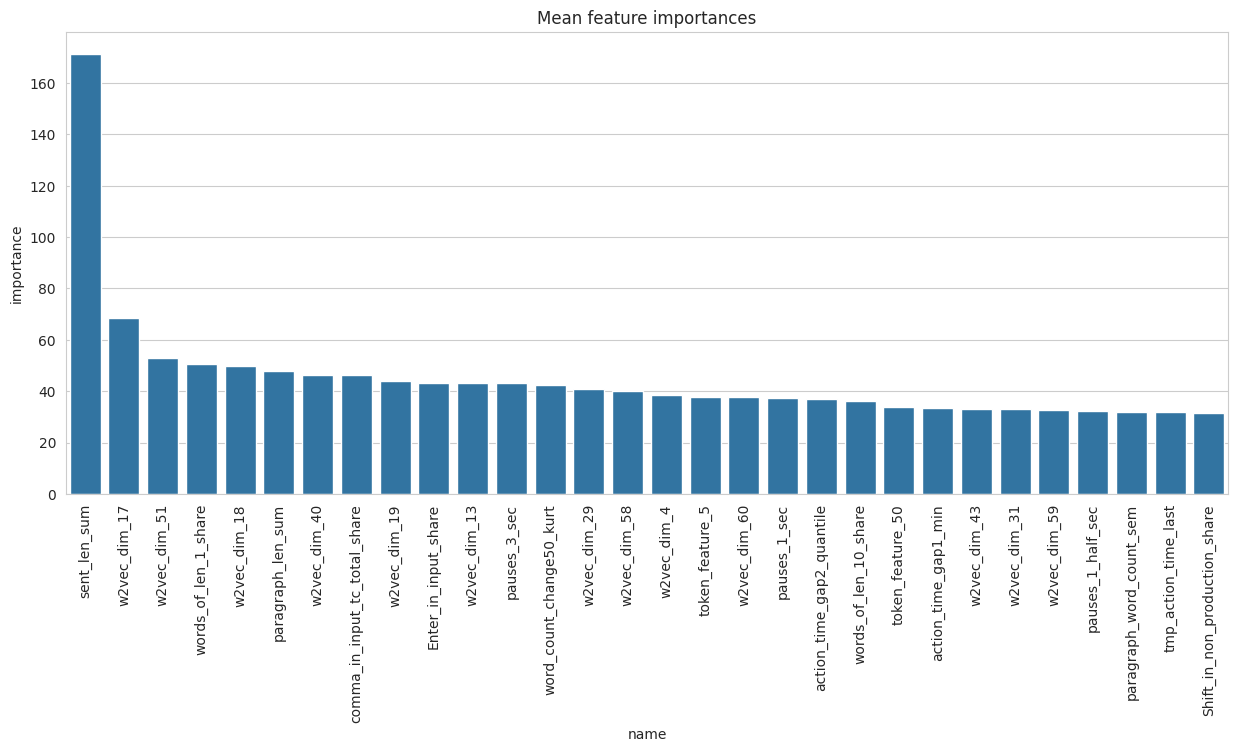

In [96]:
plt.figure(figsize=(15, 6))

ax = sns.barplot(data=feature_importance_df.head(30), x="name", y="importance")
ax.set_title(f"Mean feature importances")
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)

plt.show()

# Predicting The Test Set

We use the mean of all the predictions for all the fold models

In [97]:
# test_predict_list

In [98]:
test_feats["score"] = np.mean(test_predict_list, axis=0)

In [99]:
test_feats[["id", "score"]].to_csv("submission.csv", index=False)